
数据库获取数据

results：
    details method 中的处理过的方法、试剂名、pH、温度、浓度


In [1]:
import pandas as pd
import numpy as np
import json
import re
import string
from tqdm import tqdm
from string import digits,punctuation
from gensim.parsing.preprocessing import remove_stopwords
import pymysql
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# db = pymysql.connect(
#     host = '192.168.1.88',
#     user = 'zhangjin',
#     password = 'jin.zhang@2021',
#     database = 'Crystal'   
# )
# cursor = db.cursor()

# sql = '''
# SELECT 
#     a.pdb_id,a.entity_id,
#     a.pdbx_seq_one_letter_code_can as seq,
#     b.method as method,
#     b.pdbx_details as details
# FROM 
#     PdbEntityPoly a
# LEFT JOIN
#     PdbExptlCrystalGrow b
# ON
#     a.pdb_id = b.pdb_id
# WHERE 
#     (a.type= 'polypeptide(L)' or a.type = 'polypeptide(D)')
#     and (b.method is not null or b.pdbx_details is not null )

# '''

# df = pd.read_sql(sql,db)
# df.to_csv('result_data/rawdata_from_sql.csv')

In [3]:
data =pd.read_csv('result_data/rawdata_from_sql.csv',index_col=0,keep_default_na=False,)
data.head()

,pdb_id,entity_id,seq,method,details
0,200l,1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,,pH 6.7
1,101m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ..."
2,102m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ..."
3,103m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ..."
4,105m,1,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0"


In [4]:
data['details_list'] = data['details'].str.split(', ')
data.head()

,pdb_id,entity_id,seq,method,details,details_list
0,200l,1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,,pH 6.7,[pH 6.7]
1,101m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,..."
2,102m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,..."
3,103m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,..."
4,105m,1,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0","[3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0]"


In [5]:
# 四种方法的re表达式
re_vapor = r'\b(vapo[u]?r *(diffus(ion)?)?)\b'
re.findall(re_vapor, 'vapor diffusion')

re_sit = r'\b(sit(ting)? *(drop)?)\b'
re.findall(re_sit, 'sit ing')

re_hang = r'\b(hang(ing)? *(drop)?)\b'
re.findall(re_hang,'')

re_lcp = r'\b((lipidic|lcp) *(cubic)? *(phase)?)\b'
re.findall(re_lcp,'lipidic ')

def deal_with_four_kinds_of_method(detail:str):
    '''
    获取details中的method
    -------
    input：
    details：str

    
    output：
    method_group:list
    -------
    '''
    
    method_group =[]
    
    vapor = re.findall(re_vapor,detail)
    sit = re.findall(re_sit,detail)
    hang = re.findall(re_hang, detail)
    lcp = re.findall(re_lcp, detail)
    if vapor:
        method_group.append('vapor diffusion')
    if sit:
        method_group.append('sitting drop')
    if hang:
        method_group.append('hanging drop')
    if lcp:
        method_group.append('lipidic cubic phase')    

    return method_group

In [6]:
data['method_from_details'] = data['details_list'].map(
    lambda x: deal_with_four_kinds_of_method(','.join(x))
)

In [7]:
def replace_list(list_words,value,n=''):
    for word in list_words:
        value = value.replace(word,n)
    return value

In [8]:
# 处理方法
method_map =pd.read_csv('/data01/share/protein_crystal/crystallization/data/method_map_table.csv')

list_method = [i for i in method_map['1'] if i and i != np.nan]

def get_method(dic,string):
    list_v = []
    if string:
        
        for k,v in dic.items():
        
            if k in string:
                list_v.append(v)
        return list_v
    else:
        return []

data['method_use'] = data['method'].map(lambda x:x.strip().lower() if x and not isinstance(x,float) else None)

dic_method = {i:j for i,j in zip(method_map['method_use'],method_map['1']) if j}

data['method_kind'] = data['method_use'].map(lambda x:get_method(dic_method,x))
data['method_kind'] =data['method_kind'].map(
    lambda x :[replace_list(['sitting batch','sitting drop'],i,'sitting drop').\
    replace('lcp','lipidic cubic phase').\
    replace('vapr diffusion','vapor diffusion')
    for i in x if not isinstance(i,float)])



data['method_kind'] = data['method_kind'].map( 
    lambda x:[i.strip()  for j in x for i in j.split(',') if x]
)

data['method_results'] = data['method_kind']+data['method_from_details']
data['method_results'] = data['method_results'].map(lambda x:[i for i in set(x)])

In [9]:
# 将details中的方法移除
def remove_method_from_details(details,re_):

    return re.sub(re_,'',details.lower(), re.S)
data['remove_method_from_details'] = data['details_list']
for re_ in tqdm([re_vapor,re_sit,re_hang,re_lcp]):
    data['remove_method_from_details']=data['remove_method_from_details'].map(
        lambda x:[remove_method_from_details(i,re_) for i in x if x]
    )
data.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


,pdb_id,entity_id,seq,method,details,details_list,method_from_details,method_use,method_kind,method_results,remove_method_from_details
0,200l,1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,,pH 6.7,[pH 6.7],[],None,[],[],[ph 6.7]
1,101m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,..."
2,102m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,..."
3,103m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,..."
4,105m,1,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0","[3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0]",[],None,[],[],"[3.0 m ammonium sulfate, unbuffered, ph 9.0]"


In [10]:
def re_get_and_remove(detail,re_):
    if not detail:
        return []
    else:
        # print(detail)
        get_list = []
        get_not_ph = []
        for list_vol in detail:
            # print(list_vol,re.sub(re_,'',list_vol.lower(), re.S))
            
            get_list.append(
              re.findall(re_,list_vol.lower(), re.S)
            )
            get_not_ph.append(
              re.sub(re_,'',list_vol.lower(), re.S).strip()
            )
              
        return [j[0] for i in get_list for j in i],get_not_ph

In [11]:
# 处理ph
re_ph = r'\b(ph{1}[ |=]*(\-|\+)?\d+\.?\d*)\b'

data['result_ph_and_remove']= data['remove_method_from_details'].map(
    lambda x: re_get_and_remove(x,re_ph)
)

data['unit_ph_digital'] = data['result_ph_and_remove'].map(
    lambda x:[i.replace('ph','').replace('=','').strip(' ') for i in x[0]]
)
data.head()

,pdb_id,entity_id,seq,method,details,details_list,method_from_details,method_use,method_kind,method_results,remove_method_from_details,result_ph_and_remove,unit_ph_digital
0,200l,1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,,pH 6.7,[pH 6.7],[],None,[],[],[ph 6.7],"([ph 6.7], [])",[6.7]
1,101m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,...","([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...",[9.0]
2,102m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,...","([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...",[9.0]
3,103m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,...","([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...",[9.0]
4,105m,1,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0","[3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0]",[],None,[],[],"[3.0 m ammonium sulfate, unbuffered, ph 9.0]","([ph 9.0], [3.0 m ammonium sulfate, unbuffered...",[9.0]


In [12]:
# 处理温度和将温度和ph及其他无关字段移除
re_temp = r'\b([temperature|temp]+[ ]*(\-|\+)?\d+\.?\d*[ ]*(degree|℃|°c|k))\b'

data['result_temp_and_remove']= data['result_ph_and_remove'].map(
    lambda x: re_get_and_remove(x[1],re_temp))

re_volum = r'\b((\-|\+)?\d+\.?\d*[ ]*(cm3|mm3|dm3|ml|ul|nl|m3|cc|l))\b'
data['version1']= data['result_temp_and_remove'].map(
    lambda x: re_get_and_remove(x[1],re_volum)[1])

re_time = r'(years|year|months|month|days|day|weeks|week|hours|hour|minutes|minute|seconds|second)\b'
data['version1']= data['version1'].map(
    lambda x: re_get_and_remove(x,re_time)[1])

re_not_rule = r'(@|~|#)'
data['version1']= data['version1'].map(
    lambda x: re_get_and_remove(x,re_not_rule)[1])

In [13]:
# 处理ph和温度——取其中有效字段
data['ph_results'] = data['result_ph_and_remove'].map(
    lambda x: x[0]
)
data['temperature_results'] = data['result_temp_and_remove'].map(
    lambda x: x[0]
)

In [14]:
# columns = list(data.columns[:5])+list(data.columns[-4:-2])+[data.columns[-1]]

# data[columns].to_csv('full_results_for_crystalization.csv')

In [23]:
# 处理浓度
re_get_density = r'\b(((vol/vol|volvol |v/vol|vol/v|vvol |volv |wt/v|v/wt|wtv |vwt |\\(\\)|v/v|w/v|v/w|wv |vv |vw )* *(((\-|\+)?\d+\.?\d*) *(percentage|percent|fold|mg/ml|ug/ml|kg/ml|g/ml|rpm|mm|um|vol/vol|volvol |v/vol|vol/v|vvol |volv |wt/v|v/wt|wtv |vwt |\\(\\)|v/v|w/v|v/w|wv |vv |vw |m|%)?)?)(.*?)),'
re.findall(re_get_density,'v/v0.1m v/vAmmonium tartrate, glycerol,',re.I)

def get_full_unit(str_1):
    dic = {}
    if not str_1:
        return []
    if isinstance(str_1,str):
        for i in re.findall(re_get_density, str_1,re.I):
            if i[-1]:
                  dic[i[-1].strip()] = (i[4],i[5],i[7],i[0])
        
        return dic
    else:
        print(str_1)

data['cleaned_details'] = None
data['cleaned_details'] = data['version1'].map(lambda x:get_full_unit(','.join(x)+',')if x else {})
data['cleaned_details'] = data['cleaned_details'].map(lambda x:{k.strip():v for k,v in x.items() if k and k not in ['null','nan']})
# data[list(data.columns[-2:])].to_csv('test_details.csv')

In [24]:
def re_string_remove(detail,re_):
    if not detail:
        return ''
#     if isinstance(detail,float):
#         detail = str(detail)
    else:
#         if not isinstance(detail,str):
#             detail = str(detail)

        
        get_string = re.sub(re_,'',detail.lower(), re.S).strip()
              
        return get_string

In [25]:
# 将化合物与浓度对应
re_not_rule = r'\b(vol/vol|volvol |v/vol|vol/v|vvol |volv |wt/v|v/wt|wtv |vwt |\\(\\)|v/v|w/v|v/w|wv |vv |vw |@|&|~|#)'

data['cleaned_details']= data['cleaned_details'].map(
    lambda x: {re_string_remove(i,re_not_rule).strip():v for i,v in x.items()})

data['cleaned_details'] =data['cleaned_details'].map(
    lambda x: {remove_stopwords(i).translate(
        str.maketrans(' ',' ',string.punctuation)).\
                          replace('   ', ' ').\
                          replace('  ',' ').strip()\
       
        :v for i,v in x.items() if i != ''})
# 3.peg的归一化pegXXXX
re_peg = r'\b(peg( |mme)+\d+ *k?)\b'
# re.findall(re_peg,'peg  200 peg 5')

def peg_normal(peg_name,re_peg):
    replace_words = re.findall(re_peg,peg_name)
#     print(replace_words)
    list_new_words = []
    if replace_words:
        if len(replace_words) > 0:
            for words in replace_words:
#                 print(words)
                list_new_words.append(words.replace(' ',''))
            return ','.join(list_new_words)
    return peg_name


# data['units_full_key'] =data['units_full_key'].map(lambda x:[peg_normal(i, re_peg) for i,_ in x.items() if i!= ''])
data.head()

,pdb_id,entity_id,seq,method,details,details_list,method_from_details,method_use,method_kind,method_results,remove_method_from_details,result_ph_and_remove,unit_ph_digital,result_temp_and_remove,version1,ph_results,temperature_results,units_full,cleaned_details
0,200l,1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,,pH 6.7,[pH 6.7],[],None,[],[],[ph 6.7],"([ph 6.7], [])",[6.7],"([], [])",[],[ph 6.7],[],{},{}
1,101m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,...","([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...",[9.0],"([], [3.0 m ammonium sulfate, 20 mm tris, 1mm ...","[3.0 m ammonium sulfate, 20 mm tris, 1mm edta, ]",[ph 9.0],[],"{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3...."
2,102m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,...","([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...",[9.0],"([], [3.0 m ammonium sulfate, 20 mm tris, 1mm ...","[3.0 m ammonium sulfate, 20 mm tris, 1mm edta, ]",[ph 9.0],[],"{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3...."
3,103m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta,...","([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...",[9.0],"([], [3.0 m ammonium sulfate, 20 mm tris, 1mm ...","[3.0 m ammonium sulfate, 20 mm tris, 1mm edta, ]",[ph 9.0],[],"{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3...."
4,105m,1,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0","[3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0]",[],None,[],[],"[3.0 m ammonium sulfate, unbuffered, ph 9.0]","([ph 9.0], [3.0 m ammonium sulfate, unbuffered...",[9.0],"([], [3.0 m ammonium sulfate, unbuffered, ])","[3.0 m ammonium sulfate, unbuffered, ]",[ph 9.0],[],"{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3...."


In [26]:
# 读取手动处理好的关键词映射表
df_mapdic_firststep = pd.read_csv('data/Mapdic_Firststep_1125.csv',keep_default_na=False)

In [27]:
# 阴阳离子拆分前含有的关键词数量
list_diff_raw = df_mapdic_firststep['map1_value'].groupby(df_mapdic_firststep['map1_value']).count()

list_diff = [i.split(',')for i in list_diff_raw.index]

list_diff = {j.strip() for i in list_diff for j in i}

len(list_diff)

324

In [28]:
# 阴阳离子拆分后含有的关键词数量
list_diff_raw_iron = df_mapdic_firststep['map1_iron_value'].groupby(df_mapdic_firststep['map1_iron_value']).count()

list_diff_iron = [i.split(',')for i in list_diff_raw_iron.index]

list_diff_iron = {j.strip() for i in list_diff_iron for j in i}

len(list_diff_iron)

254

In [29]:
df_mapdic_firststep

,map1_key,map1_value,map1_iron_value,map1_iron_value_number
0,znso4,zinc sulfate,"zinc,sulfate","1,1"
1,zncl2,zinc chloride,"zinc,chloride","1,2"
2,zn acetate,zinc acetate,"zinc,acetate","1,2"
3,zinc sulfate,zinc sulfate,"zinc,sulfate","1,1"
4,zinc chloride,zinc chloride,"zinc,chloride","1,2"
...,...,...,...,...
911,maltose,maltose,maltose,
912,sodium citratecitric acid,sodium citrate,"sodium,citrate","3,1"
913,peg 1,peg1,peg1,
914,heptane1,heptane,heptane,


In [30]:
# 两个映射字典：拆分前化合物，拆分后离子，映射至原表中
dic_map1_dic = {i:v for i,v in zip(df_mapdic_firststep['map1_key'],df_mapdic_firststep['map1_value'])if v}
dic_map1_iron_dic = {i:v for i,v in zip(df_mapdic_firststep['map1_key'],df_mapdic_firststep['map1_iron_value'])if v}

data['units_full_results'] =data['cleaned_details'].map(lambda x:{dic_map1_dic[i]:v for i,v in x.items() if i in dic_map1_dic.keys() if i and dic_map1_dic[i]})

data['iron_split_results'] = data['cleaned_details'].map(lambda x:{dic_map1_iron_dic[i]:v for i,v in x.items() if i in dic_map1_iron_dic.keys() if i and dic_map1_iron_dic[i]})

In [ ]:
data[list(data.columns[:5])+['method_results']+list(data.columns[-5:])].to_csv('result_data/ph_temp_conc_ironsplit_results_20211129.csv')

In [362]:
# 化合物浓度分析
dic_n = []
for i in tqdm(data['units_full_results']):
    for k,v in i.items():
        dic_n.append({k:v})

df_substance_unit = pd.DataFrame({'substance_and_unit':dic_n})

df_substance_unit['substance']= df_substance_unit['substance_and_unit'].map(
    lambda x: [i for i in x.keys()][0]
)
df_substance_unit['unit'] = df_substance_unit['substance_and_unit'].map(
    lambda x:[v for v in x.values()][0][2]
)
df_substance_unit['concentrate'] = df_substance_unit['substance_and_unit'].map(
    lambda x: [v for v in x.values()][0][1]
)
# df_substance_unit['concentrate'] = df_substance_unit['substance_and_unit'].map(
#     lambda x: eval(x) if x
# )

for idx,value in tqdm(enumerate(df_substance_unit['concentrate'])):
    try:
        df_substance_unit['concentrate'].iloc[idx] = eval(value)
    except:
        df_substance_unit['concentrate'].iloc[idx] = np.nan
df_substance_unit.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220137/220137 [00:00<00:00, 517471.91it/s]
540417it [40:02, 224.94it/s]


,substance_and_unit,substance,unit,concentrate
0,"{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....",ammonium sulfate,m,3.0
1,"{'tris': ('20 mm', '20', 'mm', '20 mm tris')}",tris,mm,20
2,"{'edta': ('1mm', '1', 'mm', '1mm edta')}",edta,mm,1
3,"{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....",ammonium sulfate,m,3.0
4,"{'tris': ('20 mm', '20', 'mm', '20 mm tris')}",tris,mm,20


In [371]:
data

,pdb_id,entity_id,seq,method,details,details_list,method_from_details,method_use,method_kind,method_results,...,result_ph_and_remove,result_temp_and_remove,unit_ph_digital,version1,units_full,units_full_key,units_full_results,ph_results,temperature_results,iron_split_results
0,200l,1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,,pH 6.7,[pH 6.7],[],None,[],[],...,"([ph 6.7], [])","([], [])",[6.7],[],{},{},{},[ph 6.7],[],{}
1,101m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],...,"([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...","([], [3.0 m ammonium sulfate, 20 mm tris, 1mm ...",[9.0],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta, ]","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....",[ph 9.0],[],"{'ammonium,sulfate': ('3.0 m', '3.0', 'm', '3...."
2,102m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],...,"([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...","([], [3.0 m ammonium sulfate, 20 mm tris, 1mm ...",[9.0],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta, ]","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....",[ph 9.0],[],"{'ammonium,sulfate': ('3.0 m', '3.0', 'm', '3...."
3,103m,1,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...","[3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA,...",[],None,[],[],...,"([ph 9.0], [3.0 m ammonium sulfate, 20 mm tris...","([], [3.0 m ammonium sulfate, 20 mm tris, 1mm ...",[9.0],"[3.0 m ammonium sulfate, 20 mm tris, 1mm edta, ]","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....",[ph 9.0],[],"{'ammonium,sulfate': ('3.0 m', '3.0', 'm', '3...."
4,105m,1,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0","[3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0]",[],None,[],[],...,"([ph 9.0], [3.0 m ammonium sulfate, unbuffered...","([], [3.0 m ammonium sulfate, unbuffered, ])",[9.0],"[3.0 m ammonium sulfate, unbuffered, ]","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....","{'ammonium sulfate': ('3.0 m', '3.0', 'm', '3....",[ph 9.0],[],"{'ammonium,sulfate': ('3.0 m', '3.0', 'm', '3...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220132,3zzn,1,MKVGIVGSGMVGSATAYALALLGVAREVVLVDLDRKLAQAHAEDIL...,"VAPOR DIFFUSION, HANGING DROP",5-MUT TT-LDH WAS CRYSTALLIZED AT 10MG/ML BY TH...,[5-MUT TT-LDH WAS CRYSTALLIZED AT 10MG/ML BY T...,[],"vapor diffusion, hanging drop","[hanging drop, vapor diffusion, vapor diffusio...","[vapor diffusion, hanging drop]",...,"([ph 9], [5-mut tt-ldh was crystallized at 10m...","([], [5-mut tt-ldh was crystallized at 10mg/ml...",[9],[5-mut tt-ldh was crystallized at 10mg/ml by t...,{'mut ttldh crystallized 10mgml drop diffusion...,{'mut ttldh crystallized 10mgml drop diffusion...,"{'peg6000': ('18', '18', '', '18-20% peg 6000'...",[ph 9],[],"{'peg6000': ('18', '18', '', '18-20% peg 6000'..."
220133,2zzc,1,MAHHHHHHVDDDDKMNGPEDLPKSYDYDLIIIGGGSGGLAAAKEAA...,"VAPOR DIFFUSION, SITTING DROP","5% PEG 3350, 0.005M Magnesium Sulfate, 0.05M M...","[5% PEG 3350, 0.005M Magnesium Sulfate, 0.05M ...",[],"vapor diffusion, sitting drop","[sitting drop, vapor diffusion, vapor diffusio...","[sitting drop, vapor diffusion]",...,"([ph 6.0], [5% peg 3350, 0.005m magnesium sulf...","([temperature 298k], [5% peg 3350, 0.005m magn...",[6.0],"[5% peg 3350, 0.005m magnesium sulfate, 0.05m ...","{'peg 3350': ('5%', '5', '%', '5% peg 3350'), ...","{'peg 3350': ('5%', '5'

In [282]:
# 化合物浓度密度曲线
grouped = df_substance_unit.groupby('substance')

list_index = list(grouped.count().index)
list_miss = []

def dist_contrate(index_):
    
    list_0 = list(df_substance_unit[df_substance_unit['substance'] == list_index[index_]]['concentrate'])
    list_0_1_percent =len([i for i in list_0 if i == np.nan or i == 0])/len(list_0)
    sns.distplot(list_0,axlabel = list_index[index_])
    plt.savefig(f'result_data/concentation_picture/{list_index[index_]}.png')
#     plt.show()

for i in range(len(list_index)):
#     plt.subplots(len(list_index),1)
    try:
        dist_contrate(i)
    except:
        list_miss.append(list[i])

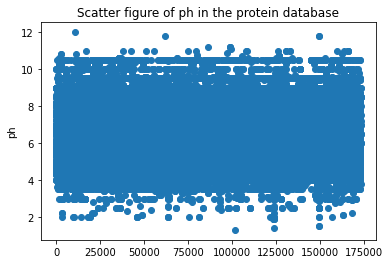

/home/lixing/miniconda3/envs/work/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


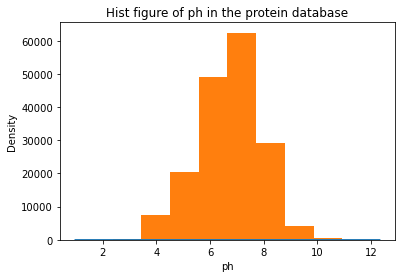

In [372]:
# ph分布
data['unit_ph_digital'] = None
data['unit_ph_digital'] = data['ph_results'].map(lambda x:[i.replace('ph','').replace('=','').strip(' ') for i in x])

list_ph = [i for i in data['unit_ph_digital']if i!='[]']

def group_inner_mean(list_string):
    mean_list = []
    if list_string == []:
        return ''
    if len(list_string)>1:
        for string in list_string:
            mean_list.append(eval(string))
        return round(np.mean(mean_list),2)
    else:
        return eval(list_string[0])
    

list_ph_end = []
for i in list_ph:
    
    end_num = group_inner_mean(i)
    list_ph_end.append(end_num)
#     print(i,group_inner_mean(i))
    

list_ph_end = [i for i in list_ph_end if i != '']

list_ph_end_range= [i for i in list_ph_end if i>0 and i<14 ]

len(list_ph_end_range)/len(list_ph_end)

plt.scatter(np.arange(len(list_ph_end_range)),list_ph_end_range)
plt.ylabel('ph')
plt.title('scatter figure of ph in the protein database'.capitalize())
plt.show()

sns.distplot(list_ph_end_range ,axlabel = 'ph')

plt.hist(list_ph_end_range)
plt.title('hist figure of ph in the protein database'.capitalize())
plt.show()

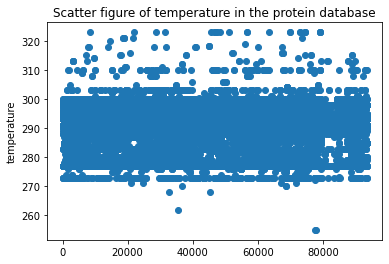

/home/lixing/miniconda3/envs/work/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


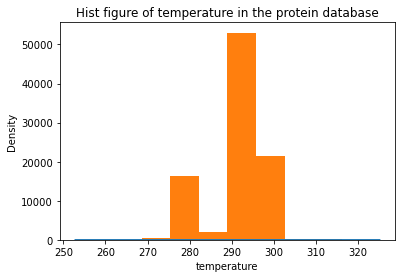

In [374]:
# 温度分布
list_temperature = [i for i in data['temperature_results'] if i != []]

len(list_temperature)

re_degree = r'((\d+)[ ]*degree)'

re.findall(re_degree,'temperature 4 degree')

re_k = r'( *([+-]?\d+\.*\d*) *k)'
re.findall(re_k,'temperature 1.4 298k')

def temp_exchange(temp_1):
    temp_2 = []
    if  not temp_1:
        temp_2 = ''
    if temp_1:
        for temp in temp_1:
#             print(temp[0],'degree' in temp[0])
            if 'degree' in temp[0]:
#                 print(temp[0])
                temp_2.append(eval(temp[1])+273) 
#                 print(temp_2)
            if 'k' in temp[0]:
                temp_2.append(eval(temp[1]))
            
            return temp_2 
        

def normalized_temperature(i):
    list_temperature = []

    if i:
        
        for oo in i:
            if 'temp' in oo:
                i_degree = re.findall(re_degree,oo)
                i_k = re.findall(re_k,oo)
    #             print(i_degree,i_k)
                if i_degree and i_k:
                    list_j = [i_degree,i_k]
                elif i_degree and not i_k:
                    list_j = [i_degree]
                elif not i_degree and i_k:
                    list_j = [i_k]
                else:
                    return ''
                for j in list_j:

                    list_temperature.append(temp_exchange(j))

    return list_temperature

data['normal_temperature'] = None
data['normal_temperature'] = data['temperature_results'].map(lambda x:normalized_temperature(x))

list_temperature =  [j for i in data['normal_temperature'] for j in i if i and j]

list_temperature = [j for i in list_temperature for j in i]

list_temperature

list_temperature_1 = [i for i in list_temperature if i]


list_temperature = [i for i in list_temperature if i>250 and i<350]

plt.scatter(np.arange(len(list_temperature)),list_temperature)
plt.ylabel('temperature')
plt.title('scatter figure of temperature in the protein database'.capitalize())
plt.show()

sns.distplot(list_temperature, axlabel = 'temperature')

plt.hist(list_temperature)
plt.title('hist figure of temperature in the protein database'.capitalize())
plt.show()

In [ ]:
# df_substance_unit[['substance','unit']].groupby(['substance','unit']).count().to_csv('unit_review.csv')

In [115]:
# count>50的关键词列表情况
list_units_full_key = [j if i else '' for i in data['units_full'] for j in i.keys()]

df_key = pd.DataFrame({'test_003':list_units_full_key})

grouped = df_key.groupby('test_003')['test_003'].describe()

get_more_50_counts = grouped[grouped['count']>50].sort_values(by = 'count',ascending = False)

get_more_50_counts

set_1 = {i.strip() for i in get_more_50_counts.index}

pd.DataFrame({'test_004':[i for i in inter]}).to_csv('test_004.csv')

set_2 = {i for i in df_mapdic_firststep['map1_key']}

set_chaji = set_1 - set_2

pd.DataFrame({'test_oo5':[i.strip() for i in set_chaji]}).to_csv('test_005.csv')

set_chaji

[re.sub(re_get_density,'',i) for i in set_chaji if not isinstance(i, float)]

df_mapdic_firststep